In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import vgg19
import torch.optim as optim
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def count_files_in_directory(directory_path):
    """Counts the number of files in the given directory."""
    return len([name for name in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, name))])

# Example usage
directory_path = '/content/drive/MyDrive/AML_Project/mirflickr'  # Replace with your folder path
num_files = count_files_in_directory(directory_path)
print(f'Number of files in the directory: {num_files}')

Number of files in the directory: 24979


# Data Loader and Pre Processing

In [ ]:
hr_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # High-resolution size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

lr_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Low-resolution size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, lr_transform, hr_transform, dataset_type='train', test_split=0.05):
        self.root_dir = root_dir
        self.lr_transform = lr_transform
        self.hr_transform = hr_transform
        all_image_files = [os.path.join(root_dir, file) for file in os.listdir(root_dir)]
        train_files, test_files = train_test_split(all_image_files, test_size=test_split, random_state=42)

        if dataset_type == 'train':
            self.image_files = train_files
        elif dataset_type == 'test':
            self.image_files = test_files

    def __len__(self):
        return 5000

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert('RGB')
        lr_image = self.lr_transform(image)
        hr_image = self.hr_transform(image)

        return lr_image, hr_image

In [ ]:
# Create datasets
train_dataset = SuperResolutionDataset('/content/drive/MyDrive/AML_Project/mirflickr', lr_transform, hr_transform, dataset_type='train')
test_dataset = SuperResolutionDataset('/content/drive/MyDrive/AML_Project/mirflickr', lr_transform, hr_transform, dataset_type='test')

In [ ]:
# Create data loaders
batch_size = 1  # Adjust as per your GPU memory
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# SRGAN

In [ ]:
class ResBlock(nn.Module):
    def __init__(self):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

    def forward(self, x):
        identity = x
        out = self.prelu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + identity
        return out


In [ ]:
class UpscaleBlock(nn.Module):
    def __init__(self):
        super(UpscaleBlock, self).__init__()
        self.conv = nn.Conv2d(64, 256, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(2)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.prelu(self.pixel_shuffle(self.conv(x)))
        return x


In [ ]:
class Generator(nn.Module):
    def __init__(self, num_res_blocks=16):
        super(Generator, self).__init__()
        self.initial = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.prelu = nn.PReLU()
        self.res_blocks = nn.Sequential(*[ResBlock() for _ in range(num_res_blocks)])
        self.conv_mid = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn_mid = nn.BatchNorm2d(64)
        self.upscale_blocks = nn.Sequential(UpscaleBlock(), UpscaleBlock())
        self.conv_output = nn.Conv2d(64, 3, kernel_size=9, padding=4)

    def forward(self, x):
        x = self.prelu(self.initial(x))
        identity = x
        x = self.res_blocks(x)
        x = self.bn_mid(self.conv_mid(x)) + identity
        x = self.upscale_blocks(x)
        x = self.conv_output(x)
        return x

In [ ]:

class DiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_bn=True):
        super(DiscriminatorBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else None
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        df = 64  # The depth of the first layer's filters
        self.initial = DiscriminatorBlock(3, df, stride=1, use_bn=False)  # Input is an RGB image

        self.blocks = nn.Sequential(
            DiscriminatorBlock(df, df, stride=2),
            DiscriminatorBlock(df, df * 2),
            DiscriminatorBlock(df * 2, df * 2, stride=2),
            DiscriminatorBlock(df * 2, df * 4),
            DiscriminatorBlock(df * 4, df * 4, stride=2),
            DiscriminatorBlock(df * 4, df * 8),
            DiscriminatorBlock(df * 8, df * 8, stride=2),
        )

        self.final = nn.Sequential(
            nn.Flatten(),
            nn.Linear(df * 8 * (128 // 16) ** 2, df * 16),  # Adjust image_size accordingly
            nn.LeakyReLU(0.2),
            nn.Linear(df * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.blocks(x)
        x = self.final(x)
        return x

In [ ]:
class SRGAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(SRGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.vgg = self.create_feature_extractor()

    def create_feature_extractor(self):
        vgg_model = vgg19(pretrained=True).features[:11]  # Using the first 11 layers of VGG19
        # Freeze VGG19 parameters
        for param in vgg_model.parameters():
            param.requires_grad = False
        return vgg_model

    def forward(self, lr_imgs):
        # Forward pass through the generator
        gen_hr_imgs = self.generator(lr_imgs)
        # Forward pass through the discriminator
        gen_hr_disc = self.discriminator(gen_hr_imgs)
        # Forward pass through VGG19 feature extractor
        gen_hr_features = self.vgg(gen_hr_imgs)

        return gen_hr_imgs, gen_hr_disc, gen_hr_features

In [ ]:
generator = Generator()
discriminator = Discriminator()

srgan = SRGAN(generator, discriminator)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 158MB/s]


In [ ]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001)

In [ ]:
# Loss functions
criterion_GAN = nn.BCELoss()
criterion_content = nn.MSELoss()

In [ ]:
# Move models and loss functions to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
srgan.to(device)
criterion_GAN.to(device)
criterion_content.to(device)

MSELoss()

In [ ]:
# Training Loop
num_epochs = 15
for epoch in range(num_epochs):
    for i, (lr_imgs, hr_imgs) in enumerate(train_dataloader):  # Assuming train_dataloader is defined

        # Move tensors to the configured device
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        # Ground truths
        valid = Variable(torch.Tensor(np.ones((lr_imgs.size(0), 1))), requires_grad=False).to(device)
        fake = Variable(torch.Tensor(np.zeros((lr_imgs.size(0), 1))), requires_grad=False).to(device)


        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(lr_imgs)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)

        # Content loss
        gen_features = srgan.vgg(gen_hr)
        real_features = srgan.vgg(hr_imgs)
        loss_content = criterion_content(gen_features, real_features.detach())

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(hr_imgs), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_dataloader)}] [D loss: {loss_D.item()}] [G loss: {loss_G.item()}]")

    # Save images at the end of each epoch
    imgs_lr = nn.functional.interpolate(lr_imgs, scale_factor=4)
    imgs_sr = gen_hr
    imgs_hr = hr_imgs
    img_grid = torch.cat((imgs_lr, imgs_sr, imgs_hr), -1)
    save_image(img_grid, f"/content/drive/MyDrive/AML_Project/{epoch}.png", normalize=False)


Streaming output truncated to the last 5000 lines.
[Epoch 14/15] [Batch 0/5000] [D loss: 0.0] [G loss: 11.721147537231445]
[Epoch 14/15] [Batch 1/5000] [D loss: 0.0] [G loss: 15.560649871826172]
[Epoch 14/15] [Batch 2/5000] [D loss: 0.0] [G loss: 16.02653694152832]
[Epoch 14/15] [Batch 3/5000] [D loss: 0.0] [G loss: 28.66628646850586]
[Epoch 14/15] [Batch 4/5000] [D loss: 0.0] [G loss: 4.345394611358643]
[Epoch 14/15] [Batch 5/5000] [D loss: 0.0] [G loss: 9.117097854614258]
[Epoch 14/15] [Batch 6/5000] [D loss: 0.0] [G loss: 9.309526443481445]
[Epoch 14/15] [Batch 7/5000] [D loss: 0.0] [G loss: 28.70012092590332]
[Epoch 14/15] [Batch 8/5000] [D loss: 0.0] [G loss: 10.66914176940918]
[Epoch 14/15] [Batch 9/5000] [D loss: 0.0] [G loss: 17.818910598754883]
[Epoch 14/15] [Batch 10/5000] [D loss: 0.0] [G loss: 11.808661460876465]
[Epoch 14/15] [Batch 11/5000] [D loss: 0.0] [G loss: 13.477062225341797]
[Epoch 14/15] [Batch 12/5000] [D loss: 0.0] [G loss: 8.947932243347168]
[Epoch 14/15] [Bat

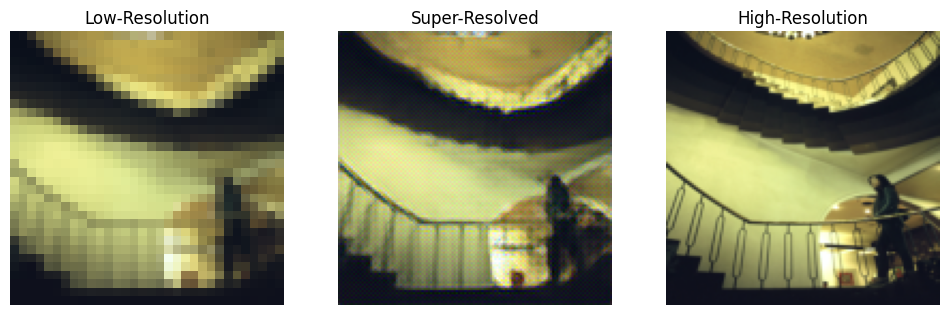

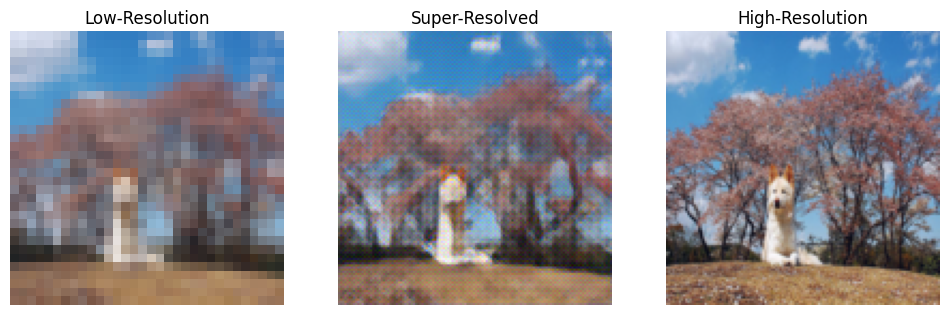

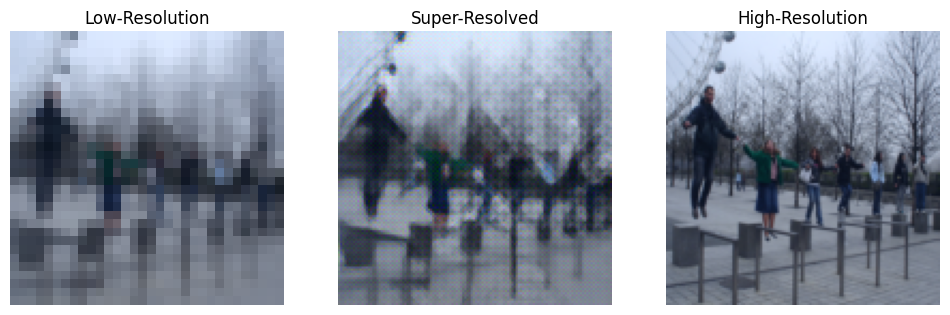

In [ ]:
def denormalize(tensor, mean, std):
    """Denormalizes a tensor image with given mean and std."""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor



import matplotlib.pyplot as plt
import torch

def plot_sample_images(fsrcnn_model, test_dataloader, device, num_samples=3):
    """Plot sample images using the FSRCNN model."""
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    generator.eval()
    with torch.no_grad():
        sample_count = 0
        for lr_imgs, hr_imgs in test_dataloader:
            if sample_count >= num_samples:
                break

            # Move tensors to the configured device
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            # Generate high resolution images
            sr_imgs = generator(lr_imgs)

            # Denormalize the images
            lr_imgs = denormalize(lr_imgs.cpu().detach(), mean, std)
            sr_imgs = denormalize(sr_imgs.cpu().detach(), mean, std)
            hr_imgs = denormalize(hr_imgs.cpu().detach(), mean, std)

            for img_index in range(lr_imgs.size(0)):
                if sample_count >= num_samples:
                    break

                # Plotting
                plt.figure(figsize=(12, 4))

                # Display low-resolution image
                plt.subplot(1, 3, 1)
                plt.imshow(lr_imgs[img_index].permute(1, 2, 0))
                plt.title('Low-Resolution')
                plt.axis('off')

                # Display super-resolved image
                plt.subplot(1, 3, 2)
                plt.imshow(sr_imgs[img_index].permute(1, 2, 0))
                plt.title('Super-Resolved')
                plt.axis('off')

                # Display high-resolution image
                plt.subplot(1, 3, 3)
                plt.imshow(hr_imgs[img_index].permute(1, 2, 0))
                plt.title('High-Resolution')
                plt.axis('off')

                plt.show()

                sample_count += 1

plot_sample_images(generator, test_dataloader, device)


# FSRCNN

In [ ]:


class FSRCNN(nn.Module):
    def __init__(self, num_channels=3, upscale_factor=4, d=56, s=12, m=4):
        super(FSRCNN, self).__init__()
        # Feature extraction layer
        self.first_part = nn.Sequential(
            nn.Conv2d(num_channels, d, kernel_size=5, padding=5 // 2),
            nn.PReLU()
        )
        # Shrinking layer
        self.mid_part1 = nn.Sequential(
            nn.Conv2d(d, s, kernel_size=1),
            nn.PReLU()
        )
        # Non-linear mapping layer
        self.mid_part2 = nn.Sequential(
            *[nn.Sequential(nn.Conv2d(s, s, kernel_size=3, padding=3 // 2), nn.PReLU()) for _ in range(m)]
        )
        # Expanding layer
        self.mid_part3 = nn.Sequential(
            nn.Conv2d(s, d, kernel_size=1),
            nn.PReLU()
        )
        # Deconvolution layer
        self.last_part = nn.ConvTranspose2d(d, num_channels, kernel_size=9, stride=upscale_factor, padding=9 // 2, output_padding=upscale_factor - 1)

    def forward(self, x):
        out = self.first_part(x)
        out = self.mid_part1(out)
        out = self.mid_part2(out)
        out = self.mid_part3(out)
        out = self.last_part(out)
        return out



In [ ]:
# Initialize the FSRCNN model
model = FSRCNN()
print(model)


FSRCNN(
  (first_part): Sequential(
    (0): Conv2d(3, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=1)
  )
  (mid_part1): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (mid_part2): Sequential(
    (0): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PReLU(num_parameters=1)
    )
    (1): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PReLU(num_parameters=1)
    )
    (2): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PReLU(num_parameters=1)
    )
    (3): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PReLU(num_parameters=1)
    )
  )
  (mid_part3): Sequential(
    (0): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=1)
  )
  (last_part): ConvT

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [ ]:
# Training loop (simplified for illustration)
for epoch in range(num_epochs):
    for data in train_dataloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/15], Loss: 0.0947
Epoch [2/15], Loss: 0.1200
Epoch [3/15], Loss: 0.0712
Epoch [4/15], Loss: 0.0761
Epoch [5/15], Loss: 0.0254
Epoch [6/15], Loss: 0.1514
Epoch [7/15], Loss: 0.1557
Epoch [8/15], Loss: 0.0478
Epoch [9/15], Loss: 0.0366
Epoch [10/15], Loss: 0.1015
Epoch [11/15], Loss: 0.1239
Epoch [12/15], Loss: 0.0569
Epoch [13/15], Loss: 0.0593
Epoch [14/15], Loss: 0.0461
Epoch [15/15], Loss: 0.0942


In [ ]:
def denormalize(tensor, mean, std):
    """Denormalizes a tensor image with given mean and std."""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor



import matplotlib.pyplot as plt
import torch

def plot_sample_images(fsrcnn_model, test_dataloader, device, num_samples=3):
    """Plot sample images using the FSRCNN model."""
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    fsrcnn_model.eval()
    with torch.no_grad():
        sample_count = 0
        for lr_imgs, hr_imgs in test_dataloader:
            if sample_count >= num_samples:
                break

            # Move tensors to the configured device
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            # Generate high-resolution images
            sr_imgs = fsrcnn_model(lr_imgs)

            # Denormalize the images
            lr_imgs = denormalize(lr_imgs.cpu().detach(), mean, std)
            sr_imgs = denormalize(sr_imgs.cpu().detach(), mean, std)
            hr_imgs = denormalize(hr_imgs.cpu().detach(), mean, std)

            for img_index in range(lr_imgs.size(0)):
                if sample_count >= num_samples:
                    break

                # Plotting
                plt.figure(figsize=(12, 4))

                # Display low-resolution image
                plt.subplot(1, 3, 1)
                plt.imshow(lr_imgs[img_index].permute(1, 2, 0).numpy())
                plt.title('Low-Resolution')
                plt.axis('off')

                # Display super-resolved image
                plt.subplot(1, 3, 2)
                plt.imshow(sr_imgs[img_index].permute(1, 2, 0).numpy())
                plt.title('Super-Resolved')
                plt.axis('off')

                # Display high-resolution image
                plt.subplot(1, 3, 3)
                plt.imshow(hr_imgs[img_index].permute(1, 2, 0).numpy())
                plt.title('High-Resolution')
                plt.axis('off')

                plt.show()

                sample_count += 1


In [ ]:
model = model.to(device)

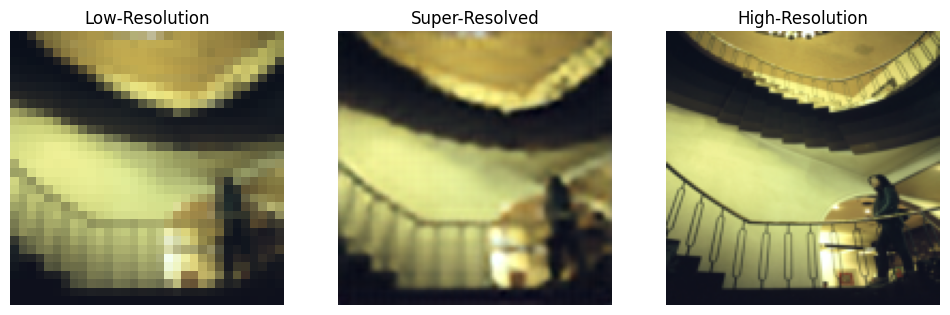

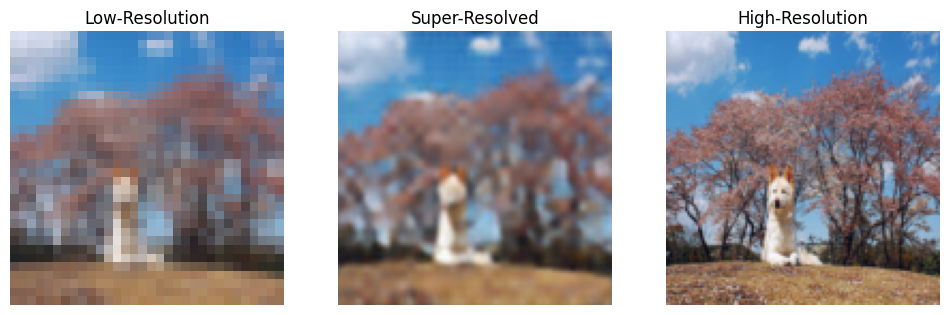

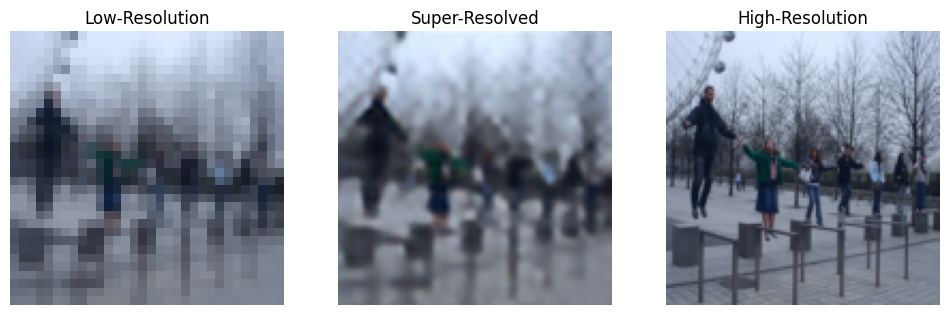

In [ ]:
# Assuming fsrcnn_model, test_dataloader, and device are already defined
plot_sample_images(model, test_dataloader, device, num_samples=3)

In [ ]:
torch.save(model.state_dict(), 'model.pt')

In [ ]:
torch.save(generator.state_dict(), 'generator.pt')

## References

- [SRGAN: Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network](https://arxiv.org/pdf/1609.04802.pdf)
- [FSRCNN: Accelerating the Super-Resolution Convolutional Neural Network](https://arxiv.org/pdf/1608.00367.pdf)
- Used ChatGPT for debugging purposes